# Project work: A mini segmentation challenge

Imaging for the Life Sciences  
MSLS / CO4: Project work

**Student**: $\Rightarrow$  Guansheng Du    
**University**: $\Rightarrow$  ZHAW  
**Semester**: $\Rightarrow$  SS24   
**Date**: $\Rightarrow$  26.05.2024 




## Table of contents

<!-- Unfortunately, the following does not always work correctly -->

* [1. Dataset](#sec_dataset)  
* [2. Preprocessing](#sec_preprocessing)  
* [3. Manual segmentation](#sec_manual_segmentation)  
* [4. Automated segmentation](#sec_automated_segmentation)  
* [5. Evaluation](#sec_evaluation)  
* [6. Discussion](#sec_discussion)  



## Introduction

Lower-grade gliomas (LGG) are a group of WHO grade II and grade III brain tumors. In this mini project homework, I implemented a neural networking based program to segment the cancer region of a serious of MRI brain images. In this programming, the files were loaded in a dataframe `df`. 

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

For more information about the dataset:
[https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

---

## Prerequisites / Setup

$\Rightarrow$  Special setup instructions, imports and configurations go here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import pydicom
import PIL
from PIL import Image
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
from torch import optim

from torch.utils.data import Dataset


# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Enable this line if you want to use the interactive widgets
# It requires the ipympl package to be installed.
#%matplotlib widget

data_folder = '/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/'



### Help functions

In [3]:
# Sort filenames in natural order
# Generated by AI

import re

def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)



In [4]:
# Check if the file has a mask

def check_mask(file):
    # Open the file
    image = Image.open(file)

    # Convert the image to an array
    image_array = np.array(image)

    # Check if there is a white pixel
    if np.any(image_array > 0):
        return 1
    else:
        return 0

In [ ]:
def overlay_mask(image, mask):
    image = np.array(image)
    mask = np.array(mask)
    mask = mask > 0.5
    mask = mask.astype(np.uint8)

    mask = mask * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(image, contours, -1, (0, 255, 0), 1)

    return image

In [ ]:
from skimage.transform import resize

def overlay_output(image, output):
    image = resize(image, output.shape)
    image = np.array(image)
    output = np.array(output)
    output = output > 0.5
    output = output.astype(np.uint8)

    output = output * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(image, contours, -1, (255, 0, 0), 1)

    return image

In [179]:
# Display the 16 images with their masks

def image_plots(df, indices):
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    for i, index in enumerate(indices):
        image = Image.open(df.iloc[index]["image_path"])
        mask = Image.open(df.iloc[index]["mask_path"])

        ax = axs[i // 4, i % 4]
        overlay = overlay_mask(image, mask)
        ax.imshow(overlay)
        # ax.imshow(image)
        # ax.imshow(mask, cmap="jet", alpha=0.5)
        ax.axis("off")

        mask_status = "Mask" if df.iloc[index]["check_mask"] == 1 else "No mask"
        ax.set_title(f"Index: {index}\n{mask_status}")

    plt.tight_layout()
    plt.show()

In [189]:
def plot_side_by_side(image, mask, pred, title1="Image", title2="Mask", title3="Prediction"):
    image = np.array(image)
    mask = np.array(mask)
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 3, 1)

    plt.imshow(image)
    plt.title(title1)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(title2)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.title(title3)
    plt.axis("off")
    
    plt.show()

In [ ]:

def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Testing Loss")
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

---


<a id='sec_dataset'></a>

## Dataset

Build a DataFrame to store image and its mask path. 



In [6]:


# Get a list of all .tif files in the data folder
tif_files = [f for f in os.listdir(data_folder) if f.endswith(".tif")]

# Sort the list of files in natural order
tif_files = natural_sort(tif_files)


In [7]:
# Create a DataFrame

mask_files = [f for f in tif_files if "_mask" in f]
image_files = [f for f in tif_files if "_mask" not in f]

df = pd.DataFrame({"image_file": image_files, "mask_file": mask_files})
df.head()

image_file                         mask_file
0  TCGA_CS_4941_19960909_1.tif  TCGA_CS_4941_19960909_1_mask.tif
1  TCGA_CS_4941_19960909_2.tif  TCGA_CS_4941_19960909_2_mask.tif
2  TCGA_CS_4941_19960909_3.tif  TCGA_CS_4941_19960909_3_mask.tif
3  TCGA_CS_4941_19960909_4.tif  TCGA_CS_4941_19960909_4_mask.tif
4  TCGA_CS_4941_19960909_5.tif  TCGA_CS_4941_19960909_5_mask.tif

In [8]:


df['mask_path'] = df.mask_file.apply(lambda x: data_folder + x)
df['image_path'] = df.image_file.apply(lambda x: data_folder + x)

df.head()

image_file                         mask_file  \
0  TCGA_CS_4941_19960909_1.tif  TCGA_CS_4941_19960909_1_mask.tif   
1  TCGA_CS_4941_19960909_2.tif  TCGA_CS_4941_19960909_2_mask.tif   
2  TCGA_CS_4941_19960909_3.tif  TCGA_CS_4941_19960909_3_mask.tif   
3  TCGA_CS_4941_19960909_4.tif  TCGA_CS_4941_19960909_4_mask.tif   
4  TCGA_CS_4941_19960909_5.tif  TCGA_CS_4941_19960909_5_mask.tif   

                                           mask_path  \
0  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
1  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
2  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
3  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
4  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   

                                          image_path  
0  /home/gs/Desktop/SS24 CO4 Imaging for the Life...  
1  /home/gs/Desktop/SS24 CO4 Imaging for the Life...  
2  /home/gs/Desktop/SS24 CO4 Imaging for the Life...  
3  /home/gs/Desktop/SS24 CO4 Imaging for the Life...  
4  /home/gs/Desktop/SS24 CO4 Imaging for the Life...

In [9]:
df["check_mask"] = df["mask_path"].apply(check_mask)

df.head()

image_file                         mask_file  \
0  TCGA_CS_4941_19960909_1.tif  TCGA_CS_4941_19960909_1_mask.tif   
1  TCGA_CS_4941_19960909_2.tif  TCGA_CS_4941_19960909_2_mask.tif   
2  TCGA_CS_4941_19960909_3.tif  TCGA_CS_4941_19960909_3_mask.tif   
3  TCGA_CS_4941_19960909_4.tif  TCGA_CS_4941_19960909_4_mask.tif   
4  TCGA_CS_4941_19960909_5.tif  TCGA_CS_4941_19960909_5_mask.tif   

                                           mask_path  \
0  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
1  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
2  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
3  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
4  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   

                                          image_path  check_mask  
0  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0  
1  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0  
2  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0  
3  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0  
4  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0

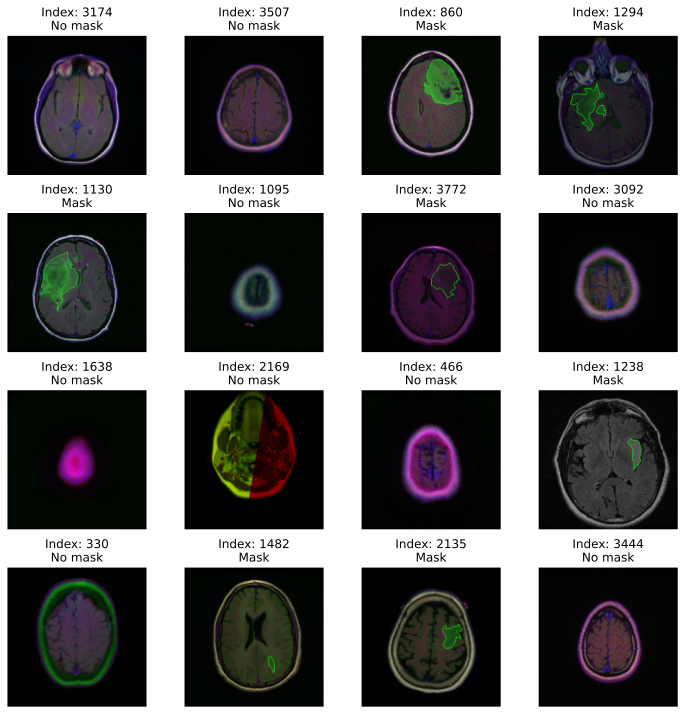

In [180]:
# Random pick 16 images from the DataFrame and make image plots

# np.random.seed(42)

# Generate 16 random indices
indices = np.random.randint(0, len(df), 16)

image_plots(df, indices)

---

<a id='sec_preprocessing'></a>

## Preprocessing

Augmentations was applied to images before the deep learning training. 


In [11]:
train_data_transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply([transforms.RandomRotation(degrees=90)], p=0.5),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

test_data_transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

In [12]:
def plot_model_results(image, mask, predict):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.33))

    axs[0].imshow(transforms.ToPILImage()(image))
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(transforms.ToPILImage()(mask), cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis("off")

    axs[2].imshow(transforms.ToPILImage()(predict.squeeze(0)), cmap="gray")
    axs[2].set_title("Predicted mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()



---

<a id='sec_manual_segmentation'></a>

## Manual segmentation


In this project, a researcher who was a medical school graduate with experience in neuroradiology imaging, manually annotated FLAIR images by drawing an outline of the FLAIR abnormality on each slice to form training data for the automatic segmentation algorithm. For more details about the manual segmentation, please refer the reference. 



---

<a id='sec_automated_segmentation'></a>

## Automated segmentation

A neural network was applied to automatically segment the images in this project. 




### Dataset preparation

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

Only images with masks were applied for training.

Build `df_mask` for training and testing. 

In [14]:
df_mask = df[df["check_mask"] == 1]
train_df = df_mask.sample(frac=0.8, random_state=42)
test_df = df_mask.drop(train_df.index)

df_mask.head()

image_file                          mask_file  \
10  TCGA_CS_4941_19960909_11.tif  TCGA_CS_4941_19960909_11_mask.tif   
11  TCGA_CS_4941_19960909_12.tif  TCGA_CS_4941_19960909_12_mask.tif   
12  TCGA_CS_4941_19960909_13.tif  TCGA_CS_4941_19960909_13_mask.tif   
13  TCGA_CS_4941_19960909_14.tif  TCGA_CS_4941_19960909_14_mask.tif   
14  TCGA_CS_4941_19960909_15.tif  TCGA_CS_4941_19960909_15_mask.tif   

                                            mask_path  \
10  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
11  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
12  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
13  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
14  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   

                                           image_path  check_mask  
10  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1  
11  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1  
12  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1  
13  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1  
14  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1

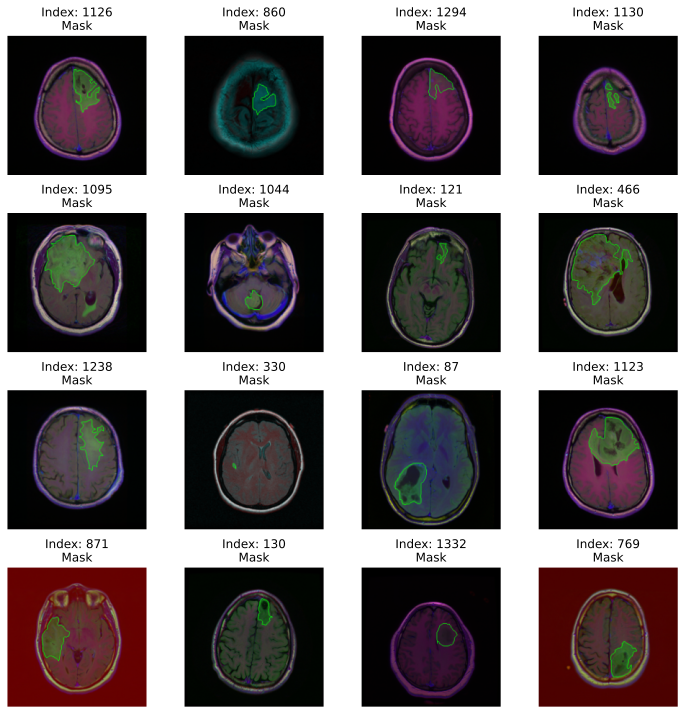

In [181]:
# Random pick 16 images from the `df_mask` and make image plots

# np.random.seed(42)
indices = np.random.randint(0, len(df_mask), 16)
image_plots(df_mask, indices)

In [16]:
# Class to create a custom dataset

class CustomImageDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def load_image(self, idx):
        image = Image.open(self.df.iloc[idx]["image_path"])
        mask = Image.open(self.df.iloc[idx]["mask_path"])
        return image, mask

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.df.iloc[idx]["image_path"]
        mask_name = self.df.iloc[idx]["mask_path"]

        image = Image.open(img_name)
        mask = Image.open(mask_name)

        image, mask = self.transforms(image, mask)

        return image, mask

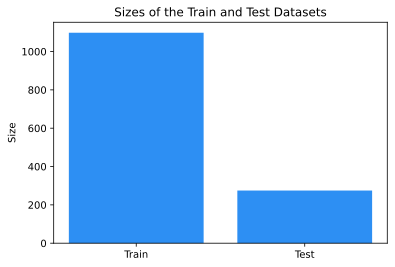

In [17]:

# Save images in the Pytorch dataset format

train_dataset = CustomImageDataset(train_df, transforms=train_data_transform)
test_dataset = CustomImageDataset(test_df, transforms=test_data_transform)

plt.figure(figsize=(6,4))
plt.bar(["Train", "Test"], [len(train_dataset), len(test_dataset)])
plt.ylabel('Size')
plt.title('Sizes of the Train and Test Datasets')
plt.show()


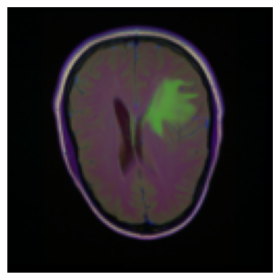

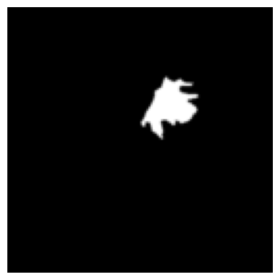

In [182]:
# Display sample images from the dataset
# np.random.seed(42)
incident = np.random.randint(0, len(train_dataset))

image, mask = train_dataset[incident]

plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(mask.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()


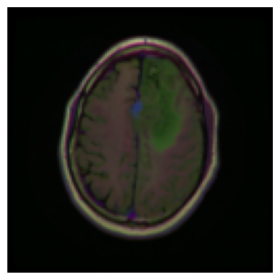

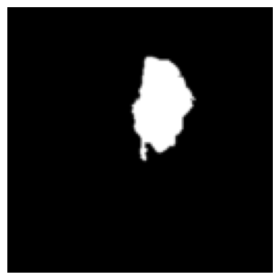

In [19]:
# Display sample images from the dataset
# np.random.seed(42)
incident = np.random.randint(0, len(test_dataset))

image, mask = test_dataset[incident]

plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(mask.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()

In [20]:
# Load the train and test datasets

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f00c376c550>,
 <torch.utils.data.dataloader.DataLoader at 0x7f00c3f15510>)

In [21]:
# Validate the train_loader

image, mask = next(iter(train_loader))
image.shape, mask.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 1, 128, 128]))

### Deep Learning Model

Use U-Net architechture for the deep learning model

In [22]:
# Model building, inspired by the U-Net from Kaggle.

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(
            in_channels // 2, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.n_channels = 3
        self.n_classes = 1
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# Create the UNet model
model = UNet().to(device)

### Training

In [23]:
# Define the loss function and optimizer

criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [24]:
# Define the loss function

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.sigmoid()  # Apply sigmoid to clamp between 0 and 1
        intersection = (
            predictions * targets
        ).sum()  # Element-wise multiplication and sum
        dice = (2.0 * intersection + self.smooth) / (
            predictions.sum() + targets.sum() + self.smooth
        )
        return 1 - dice
    
dice_loss = DiceLoss()

Epoch 1/30, Training Loss: 0.5405
Epoch 1/30, Validation Loss: 0.8663


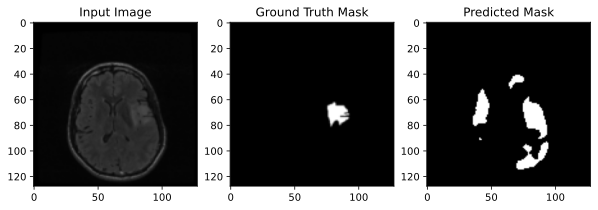

Epoch 2/30, Training Loss: 0.3978
Epoch 2/30, Validation Loss: 0.5596


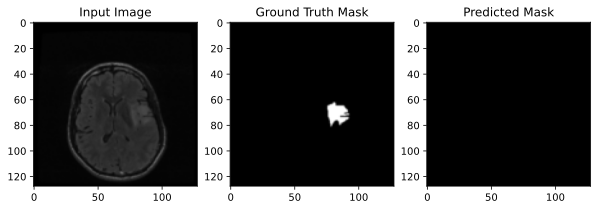

Epoch 3/30, Training Loss: 0.3497
Epoch 3/30, Validation Loss: 0.5621


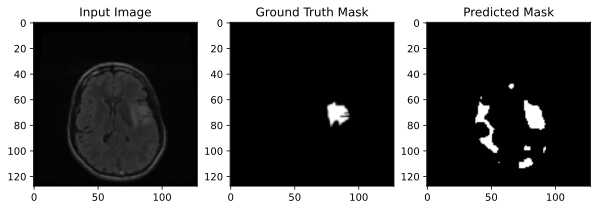

Epoch 4/30, Training Loss: 0.3025
Epoch 4/30, Validation Loss: 0.4068


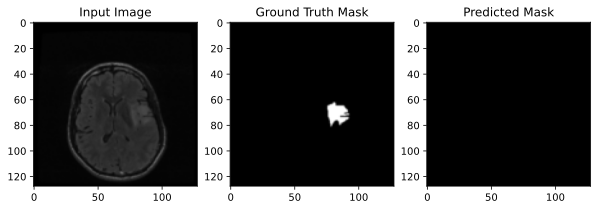

Epoch 5/30, Training Loss: 0.2927
Epoch 5/30, Validation Loss: 0.5568


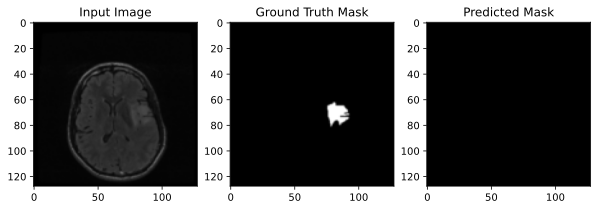

Epoch 6/30, Training Loss: 0.2762
Epoch 6/30, Validation Loss: 0.3382


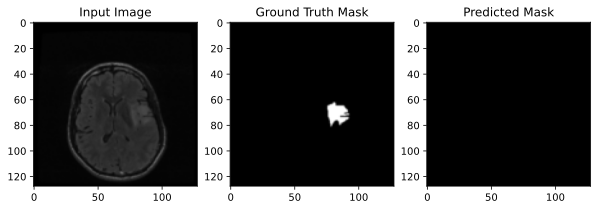

Epoch 7/30, Training Loss: 0.2811
Epoch 7/30, Validation Loss: 0.3391


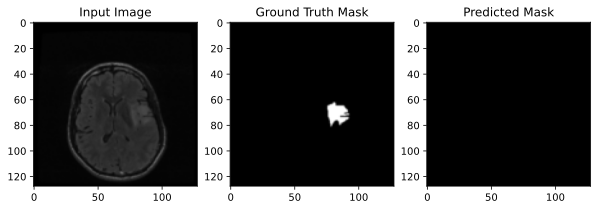

Epoch 8/30, Training Loss: 0.2697
Epoch 8/30, Validation Loss: 0.4470


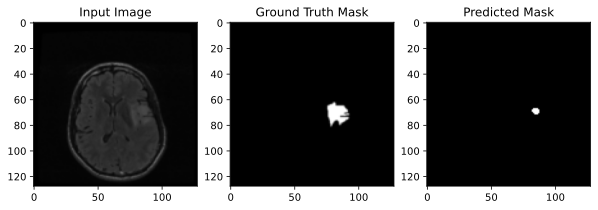

Epoch 9/30, Training Loss: 0.2553
Epoch 9/30, Validation Loss: 0.3062


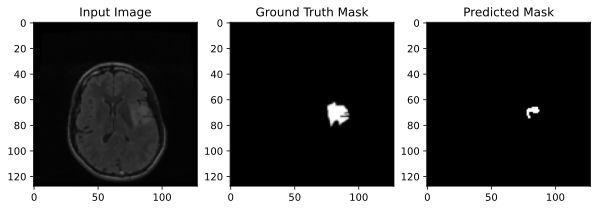

Epoch 10/30, Training Loss: 0.2577
Epoch 10/30, Validation Loss: 0.3265


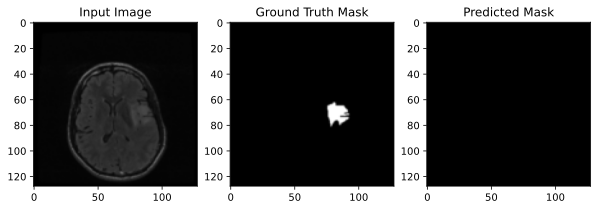

Epoch 11/30, Training Loss: 0.2547
Epoch 11/30, Validation Loss: 0.3013


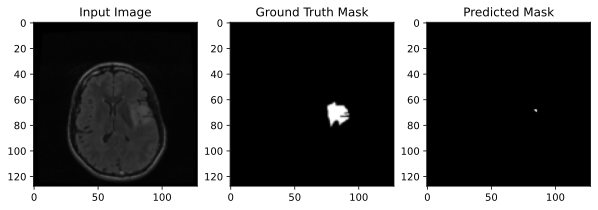

Epoch 12/30, Training Loss: 0.2476
Epoch 12/30, Validation Loss: 0.3107


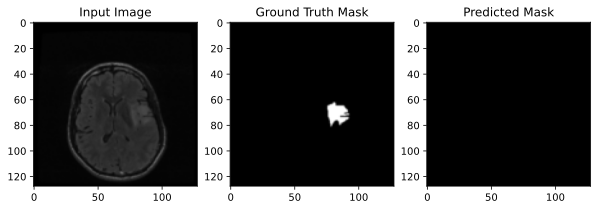

Epoch 13/30, Training Loss: 0.2574
Epoch 13/30, Validation Loss: 0.3575


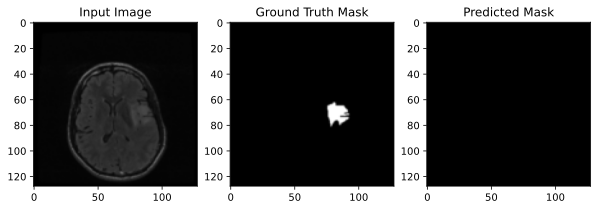

Epoch 14/30, Training Loss: 0.2561
Epoch 14/30, Validation Loss: 0.2944


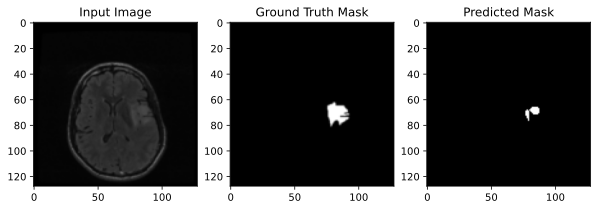

Epoch 15/30, Training Loss: 0.2342
Epoch 15/30, Validation Loss: 0.2857


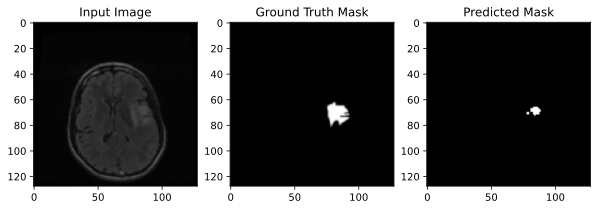

Epoch 16/30, Training Loss: 0.2300
Epoch 16/30, Validation Loss: 0.3277


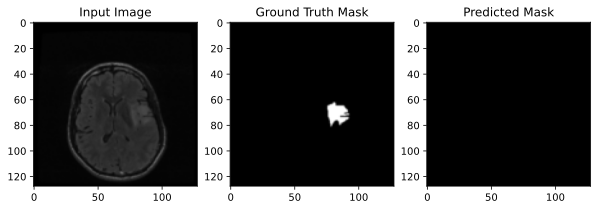

Epoch 17/30, Training Loss: 0.2470
Epoch 17/30, Validation Loss: 0.2760


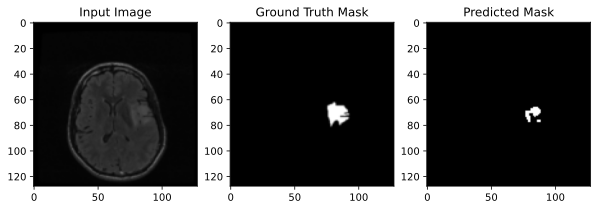

Epoch 18/30, Training Loss: 0.2273
Epoch 18/30, Validation Loss: 0.2985


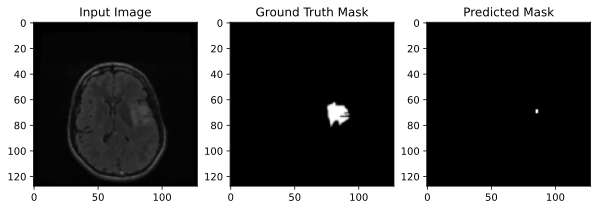

Epoch 19/30, Training Loss: 0.2395
Epoch 19/30, Validation Loss: 0.3253


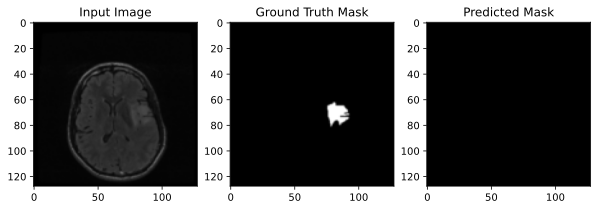

Epoch 20/30, Training Loss: 0.2377
Epoch 20/30, Validation Loss: 0.3207


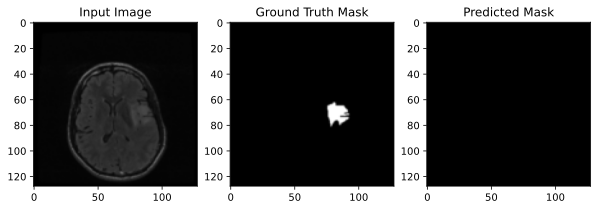

Epoch 21/30, Training Loss: 0.2311
Epoch 21/30, Validation Loss: 0.3563


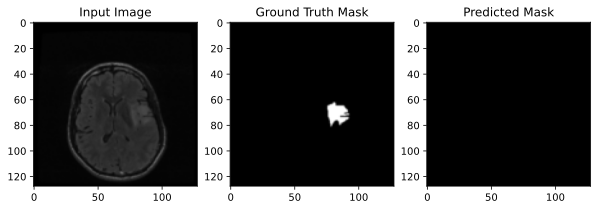

Epoch 22/30, Training Loss: 0.2360
Epoch 22/30, Validation Loss: 0.2867


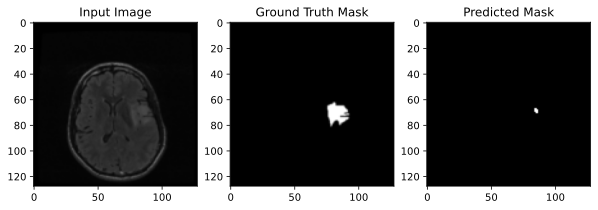

Epoch 23/30, Training Loss: 0.2265
Epoch 23/30, Validation Loss: 0.4607


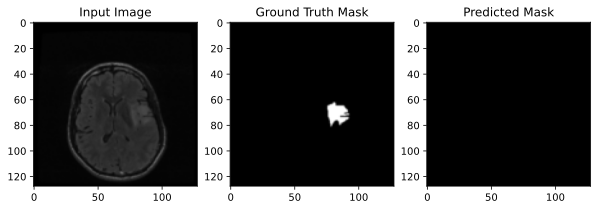

Epoch 24/30, Training Loss: 0.2217
Epoch 24/30, Validation Loss: 0.2573


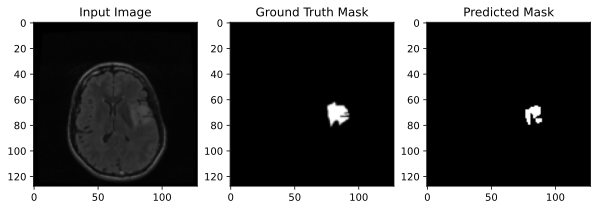

Epoch 25/30, Training Loss: 0.2121
Epoch 25/30, Validation Loss: 0.3122


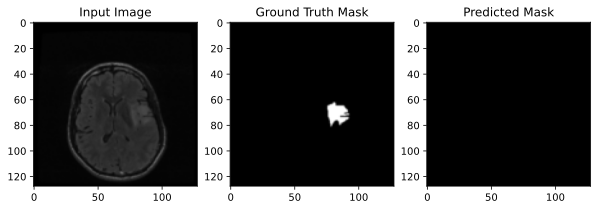

Epoch 26/30, Training Loss: 0.2233
Epoch 26/30, Validation Loss: 0.2593


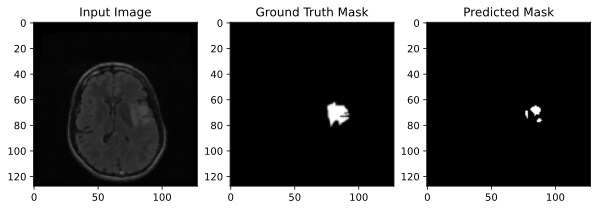

Epoch 27/30, Training Loss: 0.2064
Epoch 27/30, Validation Loss: 0.2584


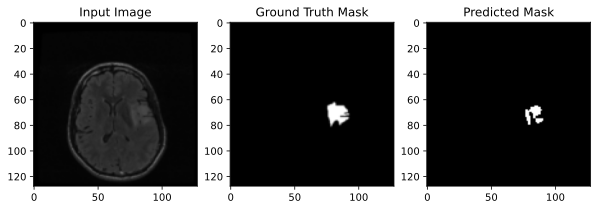

Epoch 28/30, Training Loss: 0.2055
Epoch 28/30, Validation Loss: 0.2879


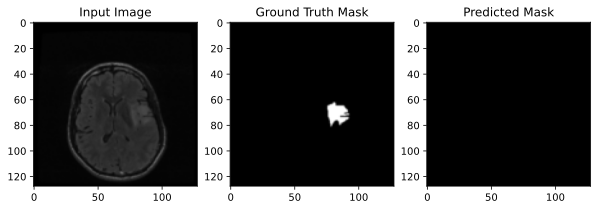

Epoch 29/30, Training Loss: 0.2032
Epoch 29/30, Validation Loss: 0.2499


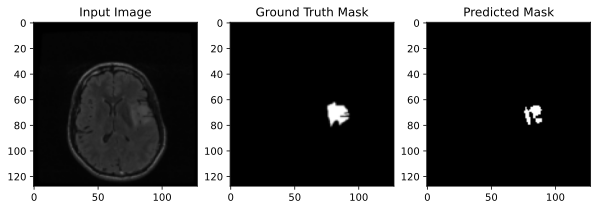

Epoch 30/30, Training Loss: 0.2059
Epoch 30/30, Validation Loss: 0.2882


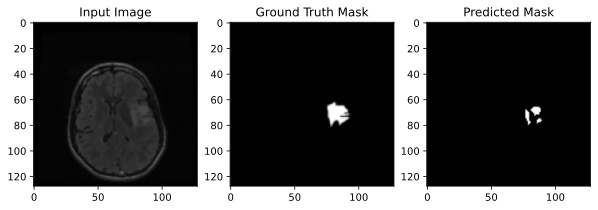

In [156]:
num_epochs = 30

torch.manual_seed(42)
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        optimizer.zero_grad()

        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        # Resize masks to match the size of outputs
        # masks = torch.nn.functional.interpolate(masks, size=outputs.size()[2:], mode='bilinear', align_corners=False).to(device)
        
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    if epoch % 1 == 0:

        model.eval()
        with torch.no_grad():
            
            testing_loss = 0.0

            for images, masks in test_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                preds = torch.sigmoid(outputs)
                preds = preds > 0.5  # Apply threshold

                loss = dice_loss(outputs, masks)
                testing_loss += loss.item() * images.size(0)
                
            val_loss = testing_loss / len(test_loader.dataset)
            val_loss_history.append(val_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

            # Visualization code (for example purposes, visualize the first batch)
            
            plot_side_by_side(images[0].cpu().permute(1,2,0), masks[0].cpu().permute(1,2,0), preds[0].cpu().numpy().squeeze())
            
            # plt.figure(figsize=(10, 5))
            # plt.subplot(1, 3, 1)
            # plt.imshow(transforms.ToPILImage()(images[0].cpu()))
            # plt.title("Input Image")
            # plt.axis("off")
# 
            # plt.subplot(1, 3, 2)
            # plt.imshow(transforms.ToPILImage()(masks[0].cpu()), cmap="gray")
            # plt.title("Ground Truth Mask")
            # plt.axis("off")
# 
            # plt.subplot(1, 3, 3)
            # plt.imshow(preds[0].cpu().numpy().squeeze(), cmap="gray")
            # plt.title("Predicted Mask")
            # plt.axis("off")
            # 
            # plt.show()
            
            #plot_model_results(images[0], masks[0], preds[0].squeeze(0))
            



In [171]:
torch.save(model.state_dict(), "unet.pth")

In [25]:
model = UNet().to(device)  # Replace with your actual model architecture
model.load_state_dict(torch.load("unet0.pth"))

<All keys matched successfully>

---

<a id='sec_evaluation'></a>

## Evaluation

$\Rightarrow$ Describe the evaluation of your results


### Goals:
* Choose an evaluation method that can compare two binary segmentation masks and computes a numeric score that describes how well these masks match (use for example the Dice score)
* Hint: specify a function `evaluate(mask1, mask2)` that computes the evaluation score(s)
* Compute mean and standard deviation of the scores of the entire dataset

In [201]:
def pred_plots(df, indices):

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    for i, index in enumerate(indices):
        image = Image.open(df.iloc[index]["image_path"])
        mask = Image.open(df.iloc[index]["mask_path"])

        ax = axs[i // 4, i % 4]
        overlay = overlay_mask(image, mask)

        output = model(test_data_transform(image).unsqueeze(0).to(device))
        output = torch.sigmoid(output)
        output = output.squeeze().cpu().detach().numpy()

        overlay = overlay_output(overlay, output)

        ax.imshow(overlay)

        # ax.imshow(image)
        # ax.imshow(mask, cmap="jet", alpha=0.5)
        ax.axis("off")

        ax.set_title(f"Index: {index}")

    plt.suptitle("Green contour: Ground Truth Mask\nRed contour: Predicted Mask")

    plt.tight_layout()
    plt.show()

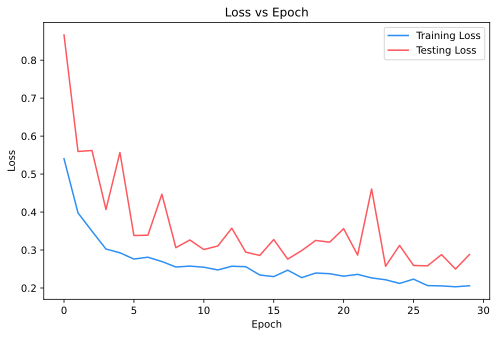

In [178]:
plot_losses(train_loss_history, val_loss_history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

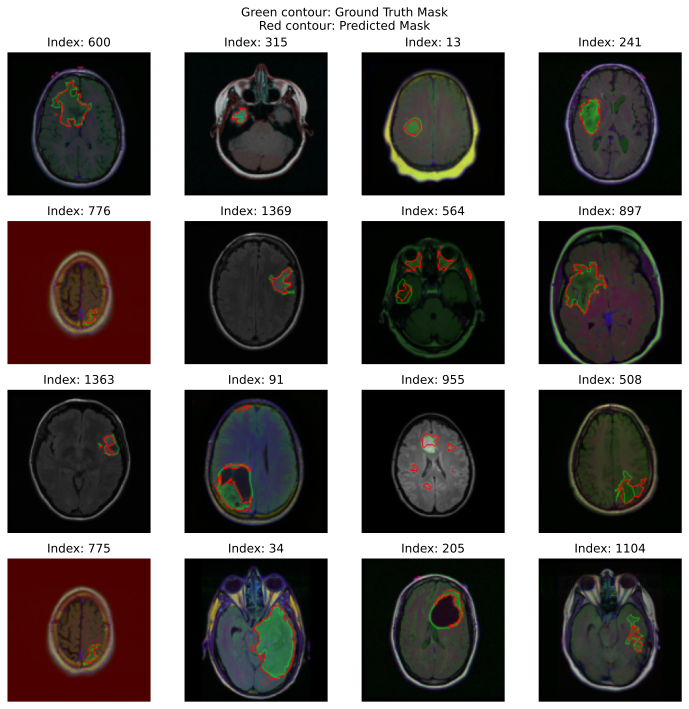

In [202]:
# Green contour presents the ground truth mask
# Red contour presents the predicted mask

# np.random.seed(42)
indices = np.random.randint(0, len(df_mask), 16)
pred_plots(df_mask, indices)

---

<a id='sec_discussion'></a>

## Discussion
In this project, a deep learning-based method was developed to segment the cancerous regions of brain tumors. The U-Net deep learning architecture, widely recognized for its effectiveness in bioimage analysis, was implemented for the segmentation task. The model demonstrated promising results, with a training loss rate of 0.2059 and a validation loss rate of 0.2882 after 30 epochs. These results suggest that the algorithm is capable of generating accurate segmentations. The model was trained in approximately 30 minutes on a GPU.

However, there is potential for further optimization of the segmentation accuracy through improved image preprocessing steps. One approach could be to fine-tune the normalization parameters for the images to minimize variability. Implementing noise reduction and contrast enhancement could also enhance the quality of the MRI images, making tumor regions more distinguishable from normal tissue. Additionally, the use of a pretrained model for skull stripping during image preprocessing could be explored. Due to the project's time constraints, a universal image processing method that could unbiasedly preprocess all 1500 images in the dataset was not identified.

The choice of loss function is another crucial aspect of deep learning programming. Exploring different loss functions could potentially improve the model's performance.






---

<a id='sec_references'></a>

## References

The code in this Jupyter Notebook was developed with assistance from GitHub Copilot. Initially, I wrote the code, and then GitHub Copilot provided revisions and improvements.


